<a href="https://colab.research.google.com/github/tazar09/un_inputs/blob/main/21apr_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [ ]:
!pip install PyPDF2
!pip install langdetect

In [7]:
import pandas as pd
pd.options.display.max_rows = 601

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import re

from PyPDF2 import PdfReader
from textblob import TextBlob

import time
from langdetect import detect

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# 1. Collect data here

In [ ]:
url = 'https://financing.desa.un.org/un-tax-convention/inputs'

In [ ]:
def scrape_link(url):
    pdf_data = []
    response = requests.get(url)
    if response.status_code == 200:
      soup = BeautifulSoup(response.content, 'html.parser')

      for link in soup.find_all('a', href=lambda href: href and href.endswith('.pdf')):
       text = link.text.strip()  # Extract link text (attribute)
       url = link.get('href')  # Extract PDF URL from 'href' attribute
       pdf_data.append({'text': text, 'url': url})

    # Create a Pandas DataFrame
      df = pd.DataFrame(pdf_data)
      return df

    else:
      print(f"Error: Website request failed with status code {response.status_code}")
      return none

In [ ]:
def scrape_and_analyze_pdfs(url):
  # Data structure to store results
  data = []
  delay = 3

  # Scrape PDF links and attributes
  pdf_data = scrape_link(url = url)

  # Download and analyze each PDF
  if pdf_data is not None:
    for index, row in pdf_data.iterrows():
      pdf_url = row['url']
      text = row['text']

      # Download the PDF (replace with error handling)
      response = requests.get(pdf_url, stream=True)
      if response.status_code == 200:
        with open(f"pdf_{index+1}.pdf", 'wb') as f:
          for chunk in response.iter_content(1024):
            f.write(chunk)

        time.sleep(delay)
        # Extract text using PyPDF2 (replace with more advanced NLP techniques)
        reader = PdfReader(f"pdf_{index+1}.pdf")
        extracted_text = ""
        for page in reader.pages:
          extracted_text += page.extract_text()

        extracted_text = extracted_text.strip()
        extracted_text = re.sub(r'\s+', ' ', extracted_text)

        data.append({'text': text, 'url': pdf_url, 'extracted_text': extracted_text})

      # Remove downloaded PDF (optional)
      # os.remove(f"pdf_{index+1}.pdf")

  # Create a Pandas DataFrame
  df = pd.DataFrame(data)
  return df

In [ ]:
# Call the function with your target URL (replace with your actual URL)
target_url = url
pdf_data = scrape_and_analyze_pdfs(target_url)

In [ ]:
# pdf_data['extracted_text'] = pdf_data['extracted_text'].apply(lambda x: re.sub(r'\s+', ' ',x))
# pdf_data['extracted_text'] = pdf_data['extracted_text'].str.strip()

def extract_country(text):
  match = re.search(r"(?<=2024-03\/)([^_]+)(?=_Input)", text)
  return match.group(1) if match else None  # Handle cases where no match is found

pdf_data['country'] = pdf_data['url'].apply(extract_country)

pdf_data['country'] = pdf_data['country'].str.replace("%", ' ')
pdf_data['country'] = pdf_data['country'].str.replace("20", '')
pdf_data['country'] = pdf_data['country'].str.strip()


In [ ]:
pdf_data = pdf_data[['text', 'country', 'url', 'extracted_text']]
pdf_data.head()

,text,country,url,extracted_text
0,African Group,African Group,https://financing.desa.un.org/sites/default/fi...,
1,Austria,Austria,https://financing.desa.un.org/sites/default/fi...,Invitation to provide inputs to the work of th...
2,Bahamas,Bahamas,https://financing.desa.un.org/sites/default/fi...,The Commonwealth of The Bahamas Input on UN Fr...
3,[ENG],Belarus,https://financing.desa.un.org/sites/default/fi...,№ й'.-ЛрШгPERMANENT MISSION OF THE REPUBLIC OF...
4,[RUS],Belarus,https://financing.desa.un.org/sites/default/fi...,№ й'.-ЛрШгPERMANENT MISSION OF THE REPUBLIC OF...


In [ ]:
pdf.loc[pdf['text'] == '[ENG]', 'text'] = pdf['country'].where(pdf['text'] == '[ENG]')
pdf['sentiment'] = pdf['extracted_text'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [ ]:
def detect_language(text):
  try:
    return detect(text)
  except:
    return None  # Handle potential errors during language detection

pdf['language'] = pdf['extracted_text'].apply(detect_language)

In [ ]:
pdf = pdf[['text', 'country', 'url', 'extracted_text', 'language', 'sentiment']]

In [ ]:
pdf.head()

,text,country,url,extracted_text,language,sentiment
0,African Group,African Group,https://financing.desa.un.org/sites/default/fi...,,None,0.000000
1,Austria,Austria,https://financing.desa.un.org/sites/default/fi...,Invitation to provide inputs to the work of th...,en,0.127652
2,Bahamas,Bahamas,https://financing.desa.un.org/sites/default/fi...,The Commonwealth of The Bahamas Input on UN Fr...,en,0.116546
3,Belarus,Belarus,https://financing.desa.un.org/sites/default/fi...,№ й'.-ЛрШгPERMANENT MISSION OF THE REPUBLIC OF...,en,0.087142
4,[RUS],Belarus,https://financing.desa.un.org/sites/default/fi...,№ й'.-ЛрШгPERMANENT MISSION OF THE REPUBLIC OF...,ru,0.077273


In [ ]:
def analyze_sentiment(text):

  # Create VADER sentiment analyzer
  analyzer = SentimentIntensityAnalyzer()

  # Analyze sentiment
  sentiment = analyzer.polarity_scores(text)

  return sentiment

In [ ]:
def sentiment_analysis_df(data):

  # Add new columns for sentiment scores
  data['sentiment'] = data['extracted_text'].apply(analyze_sentiment)
  data['compound'] = data['sentiment'].apply(lambda x: x['compound'])
  data['pos'] = data['sentiment'].apply(lambda x: x['pos'])
  data['neg'] = data['sentiment'].apply(lambda x: x['neg'])
  data['neu'] = data['sentiment'].apply(lambda x: x['neu'])  # Extract neutral score

  # Return the DataFrame with sentiment scores
  return data

In [ ]:
pdf_data = pdf

In [ ]:
pdf_sent = sentiment_analysis_df(pdf_data)  # Avoid modifying original DataFrame
pdf_sent.head()

,text,country,url,extracted_text,sentiment,language,compound,pos,neg,neu
0,African Group,African Group,https://financing.desa.un.org/sites/default/fi...,,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",None,0.0000,0.000,0.000,0.000
1,Austria,Austria,https://financing.desa.un.org/sites/default/fi...,Invitation to provide inputs to the work of th...,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",en,0.9957,0.125,0.000,0.875
2,Bahamas,Bahamas,https://financing.desa.un.org/sites/default/fi...,The Commonwealth of The Bahamas Input on UN Fr...,"{'neg': 0.037, 'neu': 0.819, 'pos': 0.144, 'co...",en,0.9996,0.144,0.037,0.819
3,Belarus,Belarus,https://financing.desa.un.org/sites/default/fi...,№ й'.-ЛрШгPERMANENT MISSION OF THE REPUBLIC OF...,"{'neg': 0.012, 'neu': 0.903, 'pos': 0.085, 'co...",en,0.9969,0.085,0.012,0.903
4,[RUS],Belarus,https://financing.desa.un.org/sites/default/fi...,№ й'.-ЛрШгPERMANENT MISSION OF THE REPUBLIC OF...,"{'neg': 0.0, 'neu': 0.967, 'pos': 0.033, 'comp...",ru,0.9810,0.033,0.000,0.967


In [ ]:
# pdf_sent.to_excel('inputs_sent.xlsx')

# 2. Start import here

In [80]:
df = pd.read_excel('/content/inputs_sent.xlsx')

In [81]:
def count_words(text):
  if isinstance(text, str):
    return len(text.split())
  else:
    return 0  # Or any other value you want for non-strings (e.g., np.NAN)

In [82]:
df['total_words'] = df['extracted_text'].apply(lambda x: count_words(x))

In [83]:
df.drop(['Unnamed: 0', 'country', 'sentiment', 'url'], axis = 1, inplace = True)
df.drop(index = [76, 4, 7, 31, 40, 69, 78], inplace = True)
df = df.query('total_words != 0')
df = df.query('total_words != 1')

In [84]:
def preprocess_text(text):
  # Lowercase the text
  text = text.lower()
  # Remove punctuation
  punctuations = "!?_/\=~`'"
  for punct in punctuations:
    text = text.replace(punct, "")
  # Return the pre-processed text
  return text

#!,.?():_;/\=~`'

In [85]:
df['text_proc'] = df['extracted_text'].apply(preprocess_text)

In [86]:
df.reset_index(inplace = True)
df.index

RangeIndex(start=0, stop=93, step=1)

In [87]:
df = df[['text', 'text_proc','total_words']]

In [88]:
df.head(5)

,text,text_proc,total_words
0,Austria,invitation to provide inputs to the work of th...,544
1,Bahamas,the commonwealth of the bahamas input on un fr...,2075
2,Belarus,№ й.-лршгpermanent mission of the republic of ...,1305
3,Belgium,written submission of belgium to the call for ...,348
4,Bolivia,plurinacional state of bolivia m i n i s t r y...,1415


# Dictionaries

In [116]:
 dic = pd.read_excel('/content/dictionaries.xlsx')

In [117]:
dic_change = dic['change'].str.replace('*', '')
list_change = list(dic_change)

In [118]:
dic_resist= dic['resistance'].str.replace('*', '')
list_resist = list(dic_resist)

In [ ]:
list_resist = list_resist[:48]

In [125]:
regex_change = r'\b\w*(?:' + '|'.join(list_change) + r')\w*\b'
regex_resist = r'\b\w*(?:' + '|'.join(list_resist) + r')\w*\b'

In [128]:
def count_matches(text):
  matches = re.findall(regex_change, text)
  return len(matches)

def count_matches_resist(text):
  matches = re.findall(regex_resist, text)
  return len(matches)

In [ ]:
df['resist']=df['text_proc'].apply(count_matches_resist)

In [131]:
df['change']=df['text_proc'].apply(count_matches)
df['change_%'] = round((df['change']/df['total_words'])*100,1)
df['resist_%'] = round((df['resist']/df['total_words'])*100,1)

In [134]:
df.drop(['change', 'resist'], axis = 1, inplace = True)

In [135]:
df.head()

,text,text_proc,total_words,change_%,resist_%
0,Austria,invitation to provide inputs to the work of th...,544,9.7,4.0
1,Bahamas,the commonwealth of the bahamas input on un fr...,2075,15.6,2.9
2,Belarus,№ й.-лршгpermanent mission of the republic of ...,1305,10.9,1.9
3,Belgium,written submission of belgium to the call for ...,348,12.9,7.2
4,Bolivia,plurinacional state of bolivia m i n i s t r y...,1415,15.5,2.2


In [137]:
df.sort_values('change_%', ascending = False).head()

,text,text_proc,total_words,change_%,resist_%
63,Committee on Fiscal Studies (CFS),to: the chair of the ad hoc committee to draft...,1218,19.5,1.5
47,UN Regional Commissions,1 regional commissions’ inputs to the ad hoc c...,4765,17.6,2.1
14,Indonesia,input for the united nations framework convent...,283,17.0,4.2
59,Center for Economic and Social Rights (CESR),1 ad hoc committee to draft terms of reference...,2171,16.9,1.2
7,Chile,input s from chile to the first substantive se...,479,16.9,3.5


In [ ]:
df.plot()

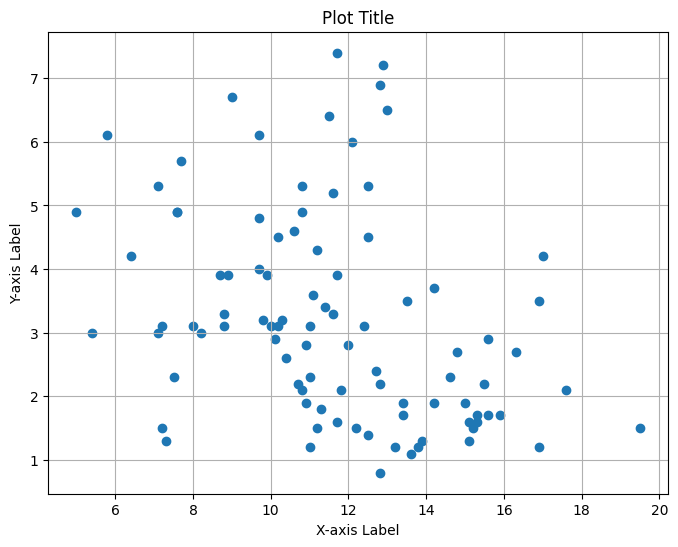

In [139]:
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'df' and the columns for plotting are 'x' and 'y'
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.scatter(df['change_%'], df['resist_%'])
plt.xlabel('X-axis Label')  # Set labels for x and y axes
plt.ylabel('Y-axis Label')
plt.title('Plot Title')  # Add a title for the plot
plt.grid(True)  # Add gridlines for better readability (optional)
plt.show()

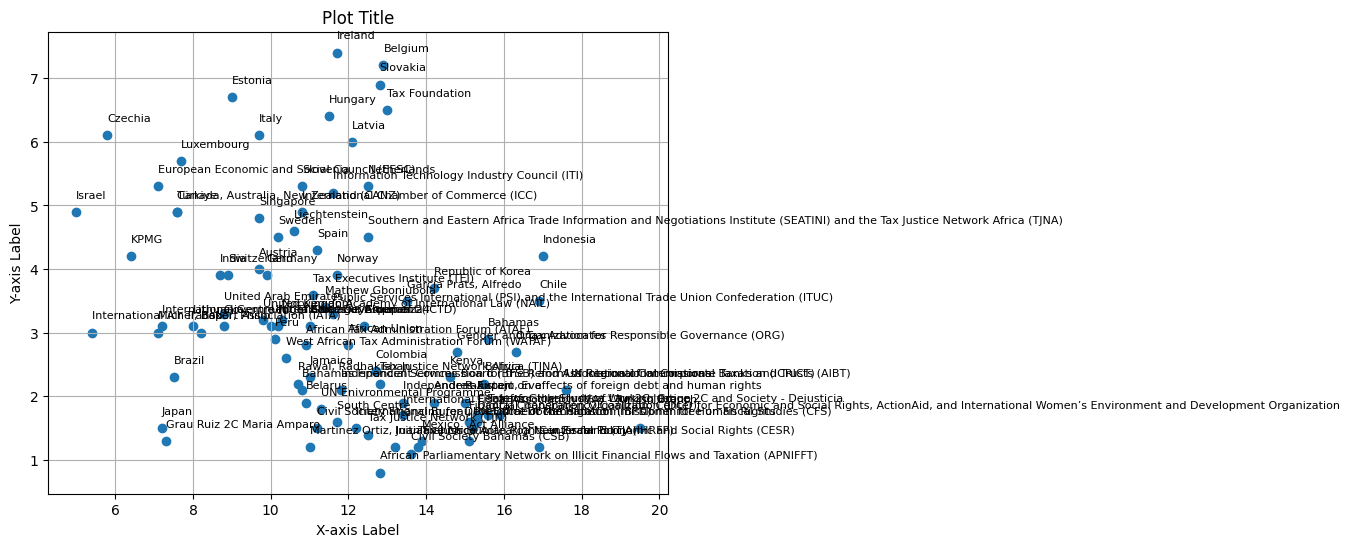

In [143]:
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.scatter(df['change_%'], df['resist_%'])

# Add labels for each point
for i, txt in enumerate(df['text']):
  plt.annotate(txt, (df['change_%'].iloc[i], df['resist_%'].iloc[i]), textcoords="offset points", xytext=(0, 10), fontsize=8)

plt.xlabel('X-axis Label')  # Set labels for x and y axes
plt.ylabel('Y-axis Label')
plt.title('Plot Title')  # Add a title for the plot
plt.grid(True)  # Add gridlines for better readability (optional)
plt.show()

In [ ]:
# df.to_excel('test_1.xlsx')

In [ ]:
# !zip -r /content/all_files.zip /content/*
# from google.colab import files
# files.download('/content/all_files.zip')